<center>
<h1><br/></h1>
<h1>Computer Vision: from Fundamentals to Applications (2024-2025)</h1>
<h2>Lab Session 5: DDPM</h2>

<h5>Tuesday, Feburary 3rd, 2025</h5>
<br>
</center>

<hr style="border:10px solid gray"> </hr>
<p style="text-align: justify;">
This handout includes <font color='blue'>coding tasks</font> and <font color='red'>questions</font>. Before the deadline, you should submit to Moodle a <B>.ipynb</B> file containing your notebook (with the gaps filled and your answers to the questions). Your answers should be well constructed and well justified. They should not repeat the question or generalities in the handout. When relevant, you are welcome to include figures, equations and tables derived from your own computations, theoretical proofs or qualitative explanations. One submission is required for each student.

<!-- The deadline for this lab is <b>January 23 -->
<!-- , 2024 11:59 AM</b>. No extension will be granted. Late policy is as follows: ]0, 24] hours late → -5 pts; ]24, 48] hours late → -10 pts; > 48 hours late → not graded (zero). -->

</p>
<hr style="border:5px solid gray"> </hr>

<h3><b>1. Introduction:</b></h2>
<p style="text-align: justify;">

In this lab we will be focusing on learning the diffusion model and DDPM structure. It consists of:

<ul>
    <li>Implement a simplist DDPM diffusion model with sampling process.</li>
    <li>Use the MNIST dataset to train the implemented dataset.</li>
    <li>Show results and visualisation with provided pretrained ckpt.</li>
</ul>

<!-- <!-- <h3><b>2. The Model:</b></h3>
<p style="text-align: justify;"> -->

Our model is based on DDPM (Denoising Diffusion Probabilistic Models
) <a href="https://arxiv.org/abs/2006.11239" target='_blank'>[2]</a>.


You will be mainlly implementing:
- noise scheduler
- p sampling
- q sampling
- training loss

<center>
<img src='https://i.ibb.co/n0x7hN7/ddpm.png' alt="drawing" width= '600px'/>

</center>

Once you have implemented and tested your model, use the provided checkpoint at this link to generate and visualise your ddpm results. Have fun!


## Model


In [27]:
import os
import math
from abc import abstractmethod
from typing import Any, List, Optional, Tuple
import sys
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [28]:
def timestep_embedding(timesteps: torch.Tensor,
                       dim: int,
                       max_period: int = 10000) -> torch.Tensor:
    """Create sinusoidal timestep embeddings.

    Args:
        timesteps (Tensor): a 1-D Tensor of N indices, one per batch element. These may be fractional.
        dim (int): the dimension of the output.
        max_period (int, optional): controls the minimum frequency of the embeddings. Defaults to 10000.

    Returns:
        Tensor: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


class TimestepBlock(nn.Module):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, t):
        """
        Apply the module to `x` given `t` timestep embeddings.
        """
        pass


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that support it as an extra input.
    """

    def forward(self, x, t):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, t)
            else:
                x = layer(x)
        return x


def norm_layer(channels: int) -> nn.GroupNorm:
    return nn.GroupNorm(32, channels)


class ResidualBlock(TimestepBlock):
    def __init__(self, in_channels, out_channels, time_channels, dropout):
        super().__init__()
        self.conv1 = nn.Sequential(
            norm_layer(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )

        # pojection for time step embedding
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, out_channels)
        )

        self.conv2 = nn.Sequential(
            norm_layer(out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()


    def forward(self,
                x: torch.Tensor,
                t: torch.Tensor) -> torch.Tensor:
        """
        `x` has shape `[batch_size, in_dim, height, width]`
        `t` has shape `[batch_size, time_dim]`
        """
        h = self.conv1(x)
        # Add time step embeddings
        h += self.time_emb(t)[:, :, None, None]
        h = self.conv2(h)
        return h + self.shortcut(x)


class AttentionBlock(nn.Module):
    def __init__(self,
                 channels: int,
                 num_heads: int = 1):
        """
        Attention block with shortcut

        Args:
            channels (int): channels
            num_heads (int, optional): attention heads. Defaults to 1.
        """
        super().__init__()
        self.num_heads = num_heads
        assert channels % num_heads == 0

        self.norm = norm_layer(channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1, bias=False)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self,
                x: torch.Tensor) -> torch.Tensor:
        B, C, H, W = x.shape
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.reshape(B*self.num_heads, -1, H*W).chunk(3, dim=1)
        scale = 1. / math.sqrt(math.sqrt(C // self.num_heads))
        attn = torch.einsum("bct,bcs->bts", q * scale, k * scale)
        attn = attn.softmax(dim=-1)
        h = torch.einsum("bts,bcs->bct", attn, v)
        h = h.reshape(B, -1, H, W)
        h = self.proj(h)
        return h + x


class Upsample(nn.Module):
    def __init__(self,
                 channels: int,
                 use_conv: bool):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self,
                x: torch.Tensor) -> torch.Tensor:
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x


class Downsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        else:
            self.op = nn.AvgPool2d(stride=2)

    def forward(self,
                x: torch.Tensor) -> torch.Tensor:
        return self.op(x)


class UNetModel(nn.Module):
    """
    The full UNet model with attention and timestep embedding
    """
    def __init__(
        self,
        in_channels=3,
        model_channels=128,
        out_channels=3,
        num_res_blocks=2,
        attention_resolutions=(8, 16),
        dropout=0,
        channel_mult=(1, 2, 2, 2),
        conv_resample=True,
        num_heads=4
    ):
        super().__init__()

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads

        # time embedding
        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        # down blocks
        self.down_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1))
        ])
        down_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResidualBlock(ch, mult * model_channels, time_embed_dim, dropout)
                ]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                self.down_blocks.append(TimestepEmbedSequential(*layers))
                down_block_chans.append(ch)
            if level != len(channel_mult) - 1: # don't use downsample for the last stage
                self.down_blocks.append(TimestepEmbedSequential(Downsample(ch, conv_resample)))
                down_block_chans.append(ch)
                ds *= 2

        # middle block
        self.middle_block = TimestepEmbedSequential(
            ResidualBlock(ch, ch, time_embed_dim, dropout),
            AttentionBlock(ch, num_heads=num_heads),
            ResidualBlock(ch, ch, time_embed_dim, dropout)
        )

        # up blocks
        self.up_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResidualBlock(
                        ch + down_block_chans.pop(),
                        model_channels * mult,
                        time_embed_dim,
                        dropout
                    )
                ]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch, conv_resample))
                    ds //= 2
                self.up_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            norm_layer(ch),
            nn.SiLU(),
            nn.Conv2d(model_channels, out_channels, kernel_size=3, padding=1),
        )

    def forward(self,
                x: torch.Tensor,
                timesteps: torch.Tensor) -> torch.Tensor:
        """Apply the model to an input batch.

        Args:
            x (Tensor): [N x C x H x W]
            timesteps (Tensor): a 1-D batch of timesteps.

        Returns:
            Tensor: [N x C x ...]
        """
        hs = []
        # time step embedding
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        # down stage
        h = x
        for module in self.down_blocks:
            h = module(h, emb)
            hs.append(h)
        # middle stage
        h = self.middle_block(h, emb)
        # up stage
        for module in self.up_blocks:
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, emb)
        return self.out(h)



In [29]:
print("nb params:", sum(p.numel() for p in UNetModel().parameters()))

nb params: 35741699


<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 1 & 2: </b><br>
How many parameters do we have in this model? And draw the architecture figure of the model.

Answer: The model has 35741699 trainable parameters.

       Input Image ([1, 28, 28])
                │
                ▼
       Initial Convolution
                │
                ▼
         Time Embedding
                │
                ▼
         Encoder Blocks (Residual Blocks, Attention, Downsampling)
                │
                ▼
         Bottleneck Block
                │
                ▼
         Decoder Blocks (Upsampling, Residual Blocks, Skip Connections)
                │
                ▼
         Output Layer (Conv)
                │
                ▼
       Generated Image (e.g., MNIST)



<hr style="border:10px solid red"> </hr>
</font></h4>

In [30]:

def linear_beta_schedule(timesteps, start_scale=0.0001, end_scale=0.02):
    """
    beta schedule
    """

    return torch.linspace(start_scale, end_scale, timesteps)



def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    """
    steps = torch.linspace(0, timesteps, timesteps + 1, dtype=torch.float64)
    alphas_cumprod = torch.cos(((steps / timesteps) + s) / (1 + s) * (torch.pi / 2)) ** 2
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])

    return betas.float()



<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 1 & 2: </b><br>
Fill the noise scheduler.
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [31]:

class GaussianDiffusion:
    def __init__(
        self,
        timesteps: int = 1000,
        beta_schedule: str = 'linear'
        ) -> None:

        self.timesteps = timesteps

        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        self.betas = betas

        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min =1e-20))

        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev)
            * torch.sqrt(self.alphas)
            / (1.0 - self.alphas_cumprod)
        )

    def _extract(self,
                 a: torch.Tensor,
                 t: torch.Tensor,
                 x_shape: Tuple[int, ...]) -> torch.Tensor:
        # get the param of given timestep t
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out

    def q_sample(self,
                 x_start: torch.Tensor,
                 t: torch.Tensor,
                 noise: Optional[torch.Tensor] = None) -> torch.Tensor:
        # forward diffusion (using the nice property): q(x_t | x_0)
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise



    def q_mean_variance(self,
                        x_start: torch.Tensor,
                        t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Get the mean and variance of q(x_t | x_0).
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    def q_posterior_mean_variance(self,
                                  x_start: torch.Tensor,
                                  x_t: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def predict_start_from_noise(self,
                                 x_t: torch.Tensor,
                                 t: torch.Tensor,
                                 noise: torch.Tensor) -> torch.Tensor:

        # compute x_0 from x_t and pred noise: the reverse of `q_sample`

        # from x_t to x_0, Hint: Eq. 15 in DDPM

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_t.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_t.shape)
        x0 = (x_t - sqrt_one_minus_alphas_cumprod_t * noise) / sqrt_alphas_cumprod_t
        return x0


    def p_mean_variance(self,
                        model: nn.Module,
                        x_t: torch.Tensor,
                        t: torch.Tensor,
                        clip_denoised: bool = True) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # compute predicted mean and variance of p(x_{t-1} | x_t)
        # predict noise using model
        pred_noise = model(x_t, t)
        # get the predicted x_0: different from the algorithm2 in the paper

        # model_mean, posterior_variance, posterior_log_variance
        # the predicted mean, variance and log variance of p(x_{t-1} | x_t)
        # do not forget to clip the denoised x_0 by
        # torch.clamp(x_reconstructed, min=-1., max=1.)

        x_reconstructed = self.predict_start_from_noise(x_t, t, pred_noise)
        if clip_denoised:
            x_reconstructed = torch.clamp(x_reconstructed, -1., 1.)
        model_mean, posterior_variance, posterior_log_variance = self.q_posterior_mean_variance(x_reconstructed, x_t, t)
        return model_mean, posterior_variance, posterior_log_variance

    @torch.no_grad()
    def p_sample(self,
                 model: nn.Module,
                 x_t: torch.Tensor,
                 t: torch.Tensor,
                 clip_denoised: bool = True) -> torch.Tensor:
        # denoise_step: sample x_{t-1} from x_t and pred_noise
        # predict mean and variance
        model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t, clip_denoised=clip_denoised)
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img

    @torch.no_grad()
    def p_sample_loop(self,
                      model: nn.Module,
                      shape: Tuple[int, ...]) -> List[torch.Tensor]:
        # denoise: reverse diffusion
        batch_size = shape[0]
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        # loop sample x_{t-1} from x_t
        # return the list of sampled images

        img = torch.randn(shape, device=device)
        imgs = []
        for t_ in reversed(range(self.timesteps)):
            t_tensor = torch.full((batch_size,), t_, device=device, dtype=torch.long)
            img = self.p_sample(model, img, t_tensor, clip_denoised=True)
            # Print debug information every 50 timesteps using the integer value
            # if t_int % 50 == 0:
                # print(f"At timestep {t_int}: min {img.min().item()}, max {img.max().item()}")
                # sys.stdout.flush()
            imgs.append(img)

        return imgs

    @torch.no_grad()
    def sample(self,
               model: nn.Module,
               image_size: int,
               batch_size: int = 8,
               channels: int = 3) -> List[torch.Tensor]:
        # sample new images
        return self.p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

    def train_losses(self,
                     model: nn.Module,
                     x_start: torch.Tensor,
                     t: torch.Tensor) -> torch.Tensor:
        """ compute train losses """
        # generate random noise
        noise = torch.randn_like(x_start)

        # 1. noised_x,
        # 2. predicted_noise,
        # 3. compare it with sampled noise

        noised_x = self.q_sample(x_start, t, noise)
        predicted_noise = model(noised_x, t)
        loss = F.mse_loss(predicted_noise, noise)
        return loss

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 3: </b><br>
Fill the training code of the DDPM.
<hr style="border:10px solid blue"> </hr>
</font></h4>
Including:

q_sample; predict_start_from_noise; train_losses;

Test the forward

In [32]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

%matplotlib inline

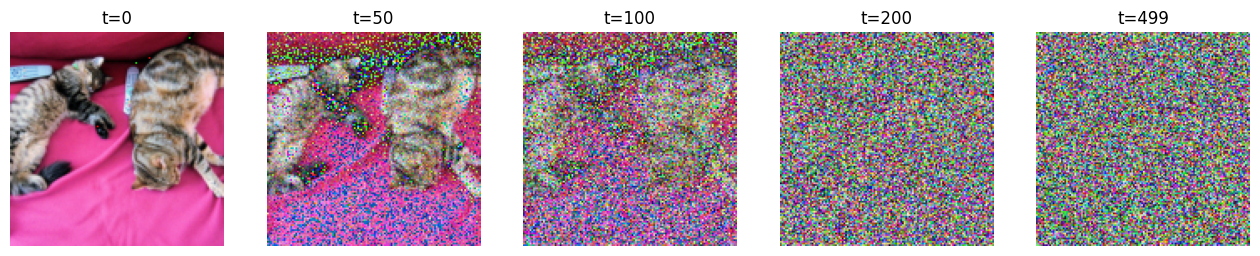

In [33]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

image_size = 128
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

x_start = transform(image).unsqueeze(0)

gaussian_diffusion = GaussianDiffusion(timesteps=500)

plt.figure(figsize=(16, 8))
for idx, t in enumerate([0, 50, 100, 200, 499]):
    x_noisy = gaussian_diffusion.q_sample(x_start, t=torch.tensor([t]))
    noisy_image = (x_noisy.squeeze().permute(1, 2, 0) + 1) * 127.5
    noisy_image = noisy_image.numpy().astype(np.uint8)
    plt.subplot(1, 5, 1 + idx)
    plt.imshow(noisy_image)
    plt.axis("off")
    plt.title(f"t={t}")

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 5: </b><br>
Test your q_sample on images, show the results.

You should have something similar to:

<img src="https://i.ibb.co/KWT02w9/q-sample.png"
     alt=""
     style="" />
<hr style="border:10px solid blue"> </hr>
</font></h4>

## Training

Preparing Dataset: we are training on MNIST

In [34]:
batch_size = 64
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Model

In [35]:
# define model and diffusion
timesteps = 500
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

Start training for 10 epochs

In [36]:
import time

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    start_time = time.time()

    for batch_idx, (images, _) in enumerate(train_loader):
        images = images.to(device)
        optimizer.zero_grad()
        t = torch.randint(0, timesteps, (images.size(0),), device=device, dtype=torch.long)
        loss = gaussian_diffusion.train_losses(model, images, t)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx}/{len(train_loader)}] Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    end_time = time.time()
    print(f"Epoch [{epoch+1}/{num_epochs}] completed in {end_time - start_time:.2f} seconds, Average Loss: {avg_loss:.4f}")

torch.save(model.state_dict(), "model.ckpt")

Epoch [1/30] Batch [0/938] Loss: 1.1108
Epoch [1/30] Batch [100/938] Loss: 0.0515
Epoch [1/30] Batch [200/938] Loss: 0.0453
Epoch [1/30] Batch [300/938] Loss: 0.0489
Epoch [1/30] Batch [400/938] Loss: 0.0333
Epoch [1/30] Batch [500/938] Loss: 0.0528
Epoch [1/30] Batch [600/938] Loss: 0.0460
Epoch [1/30] Batch [700/938] Loss: 0.0360
Epoch [1/30] Batch [800/938] Loss: 0.0487
Epoch [1/30] Batch [900/938] Loss: 0.0330
Epoch [1/30] completed in 47.19 seconds, Average Loss: 0.0526
Epoch [2/30] Batch [0/938] Loss: 0.0333
Epoch [2/30] Batch [100/938] Loss: 0.0386
Epoch [2/30] Batch [200/938] Loss: 0.0346
Epoch [2/30] Batch [300/938] Loss: 0.0399
Epoch [2/30] Batch [400/938] Loss: 0.0376
Epoch [2/30] Batch [500/938] Loss: 0.0404
Epoch [2/30] Batch [600/938] Loss: 0.0362
Epoch [2/30] Batch [700/938] Loss: 0.0430
Epoch [2/30] Batch [800/938] Loss: 0.0336
Epoch [2/30] Batch [900/938] Loss: 0.0325
Epoch [2/30] completed in 47.01 seconds, Average Loss: 0.0361
Epoch [3/30] Batch [0/938] Loss: 0.0345


<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 6: Train your model! </b><br>

Try to train it for 20-50 epochs.

Then use the ckpt here for sampling: [ckpt_epoch_1000.ckpt](https://drive.google.com/file/d/1W2Q95cU_kkBFm09qILkOwkwSTbnYe9Uf/view?usp=sharing)

<hr style="border:10px solid blue"> </hr>
</font></h4>

## Testing


In [37]:
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model.load_state_dict(torch.load("epoch_1000.ckpt", map_location=device))

model.to(device)
model.eval()

<ipython-input-37-82b322ad7e57>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("epoch_1000.ckpt", map_location=device))


UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=96, out_features=384, bias=True)
    (1): SiLU()
    (2): Linear(in_features=384, out_features=384, bias=True)
  )
  (down_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResidualBlock(
        (conv1): Sequential(
          (0): GroupNorm(32, 96, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (time_emb): Sequential(
          (0): SiLU()
          (1): Linear(in_features=384, out_features=96, bias=True)
        )
        (conv2): Sequential(
          (0): GroupNorm(32, 96, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0, inplace=False)
          (3): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (shortcut): Identity()
    

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 6: Sample images from your trained model </b><br>

Complete the code for sampling images (e.g. with batch size = 64)

<hr style="border:10px solid blue"> </hr>
</font></h4>

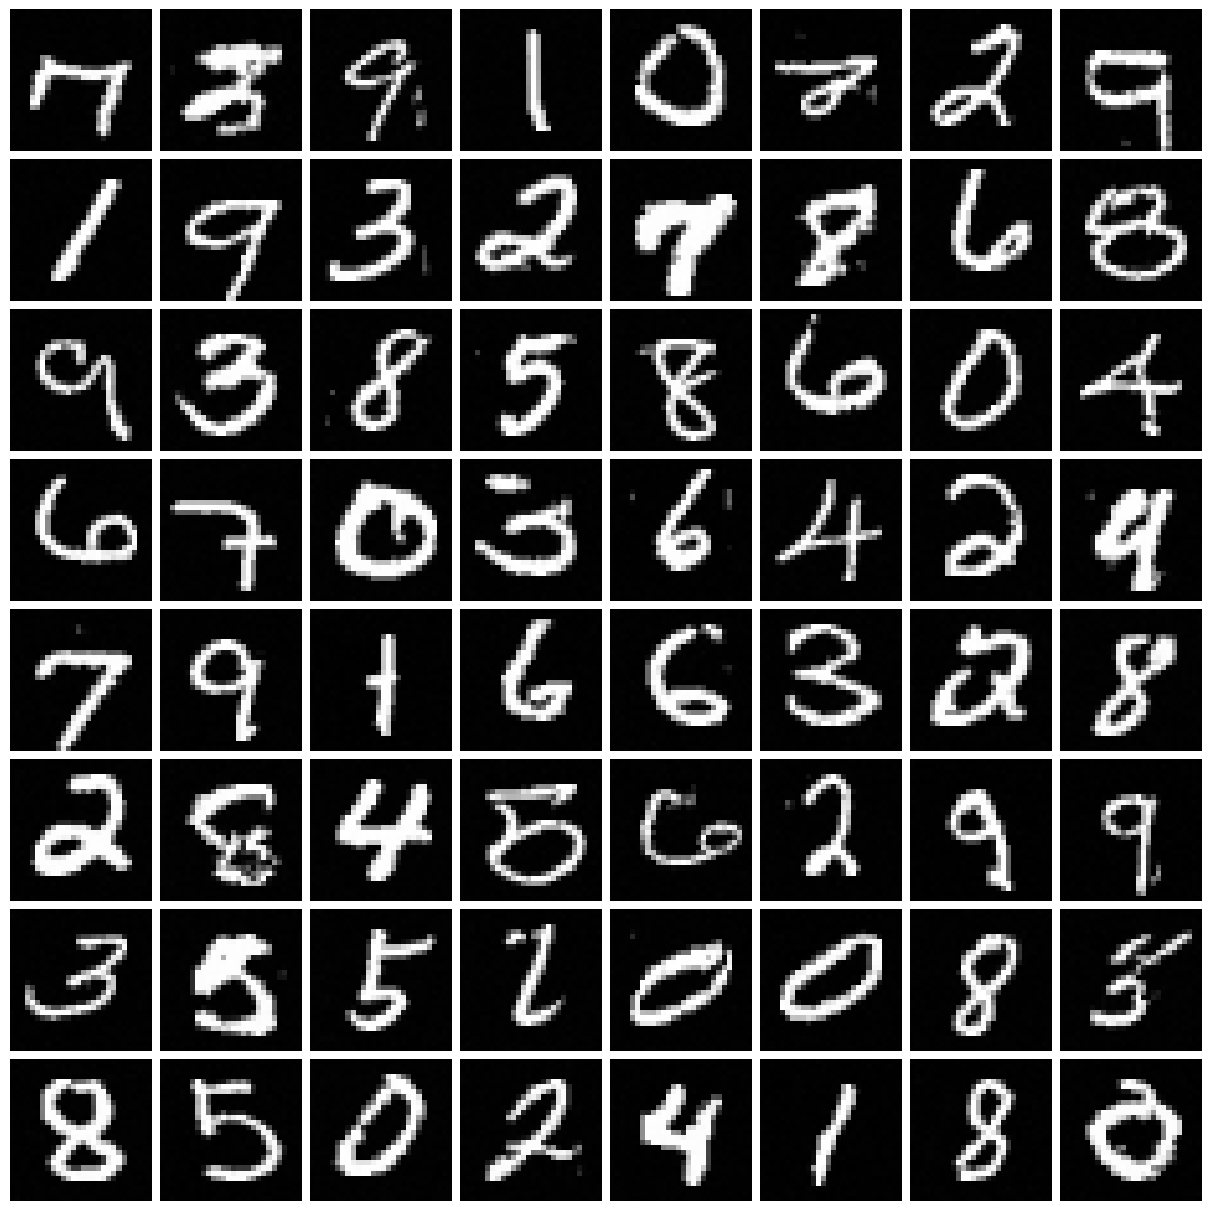

In [38]:
generated_images = gaussian_diffusion.p_sample_loop(model, shape=(64, 1, 28, 28))

# generate new images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images[-1].cpu().reshape(8, 8, 28, 28)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 7: Show the diffusion evolution step by step </b><br>
Write visualisation code to show the gradual diffusing steps.

<hr style="border:10px solid blue"> </hr>
</font></h4>

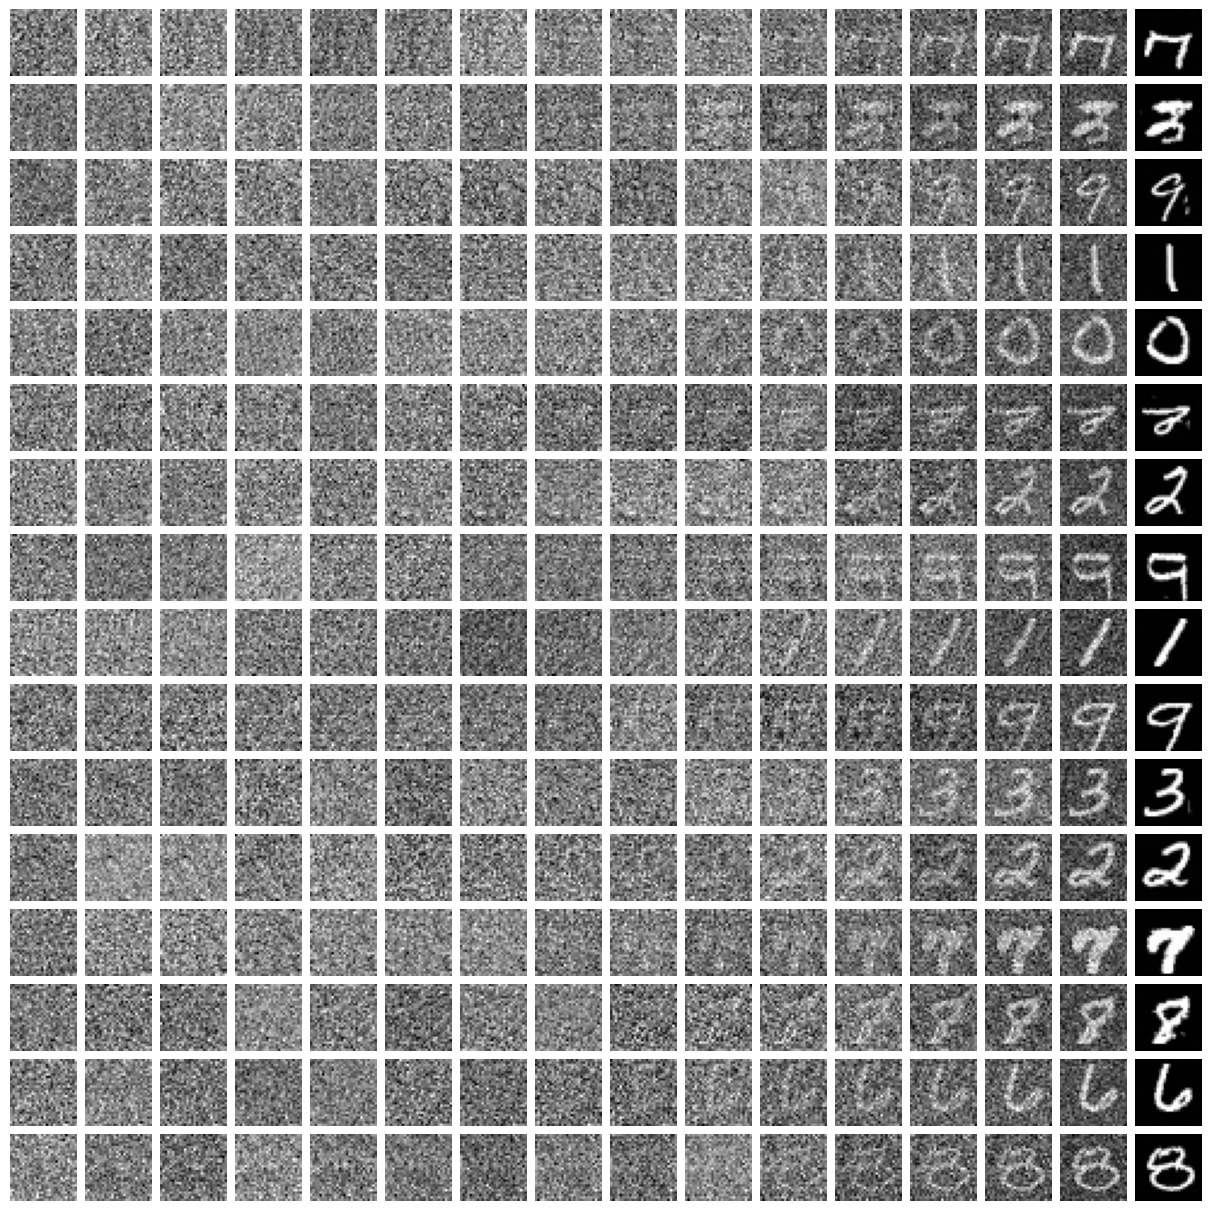

In [39]:
# show the denoise steps
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(16, 16)

for n_row in range(16):
    for n_col in range(16):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        t_idx = (timesteps // 16) * n_col if n_col < 15 else -1
        img = generated_images[t_idx][n_row].cpu().reshape(28, 28)
        f_ax.imshow((img+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>Task 8: Compare your trained checkpoints with downloaded one on samplings. </b><br>


<hr style="border:10px solid blue"> </hr>
</font></h4>

<ipython-input-42-09023d2aa832>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_download.load_state_dict(torch.load("epoch_1000.ckpt", map_location=device))
<ipython-

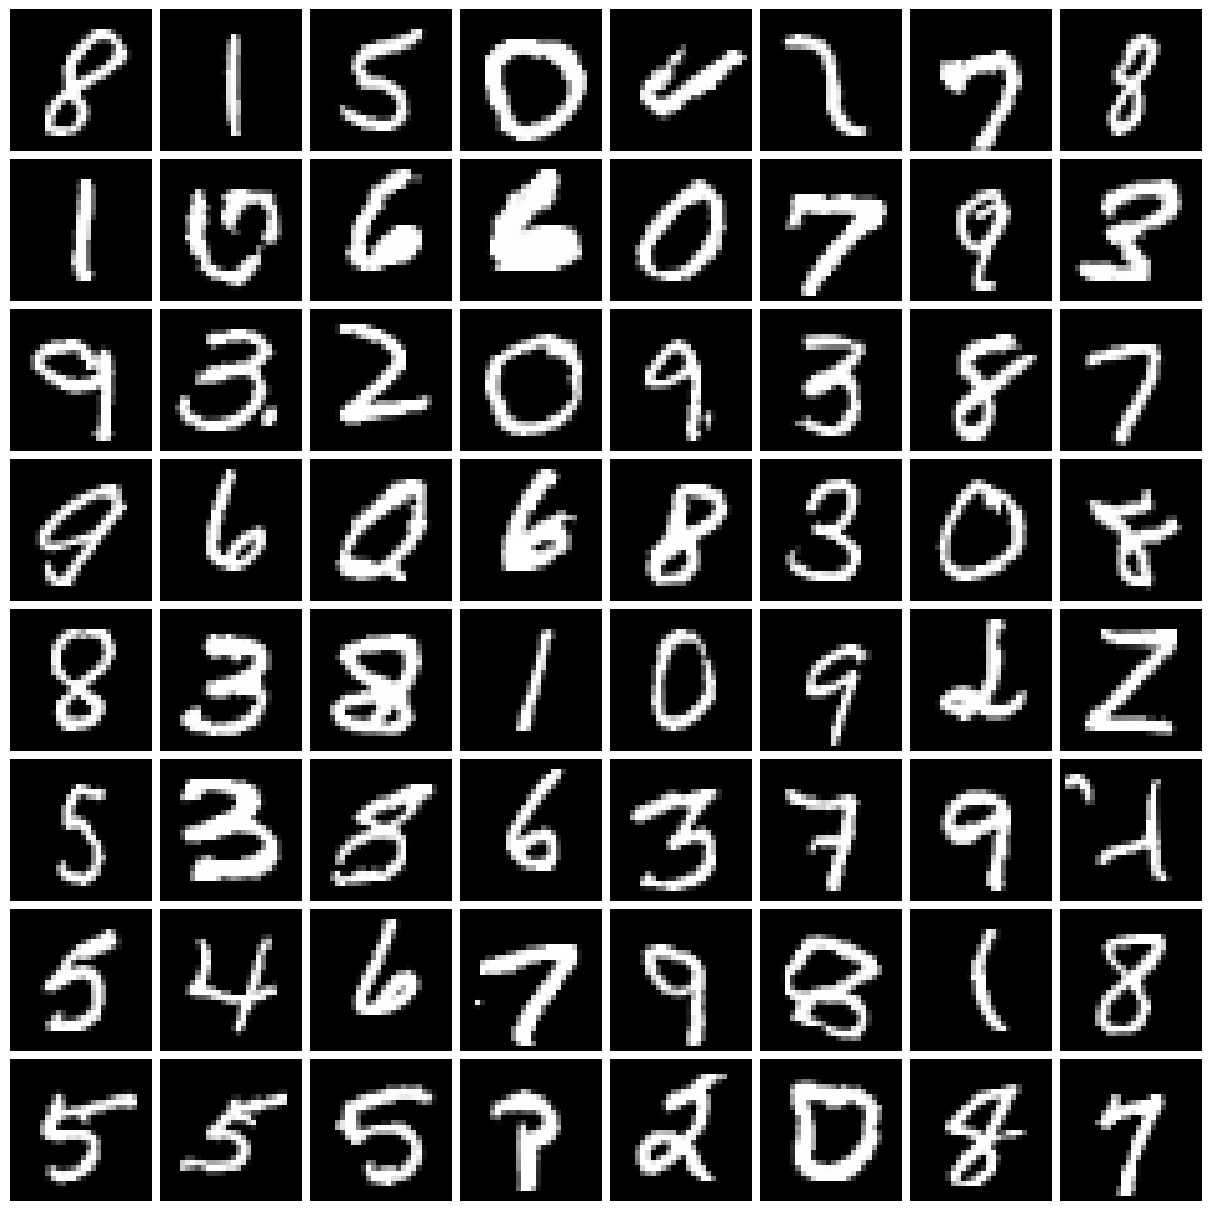

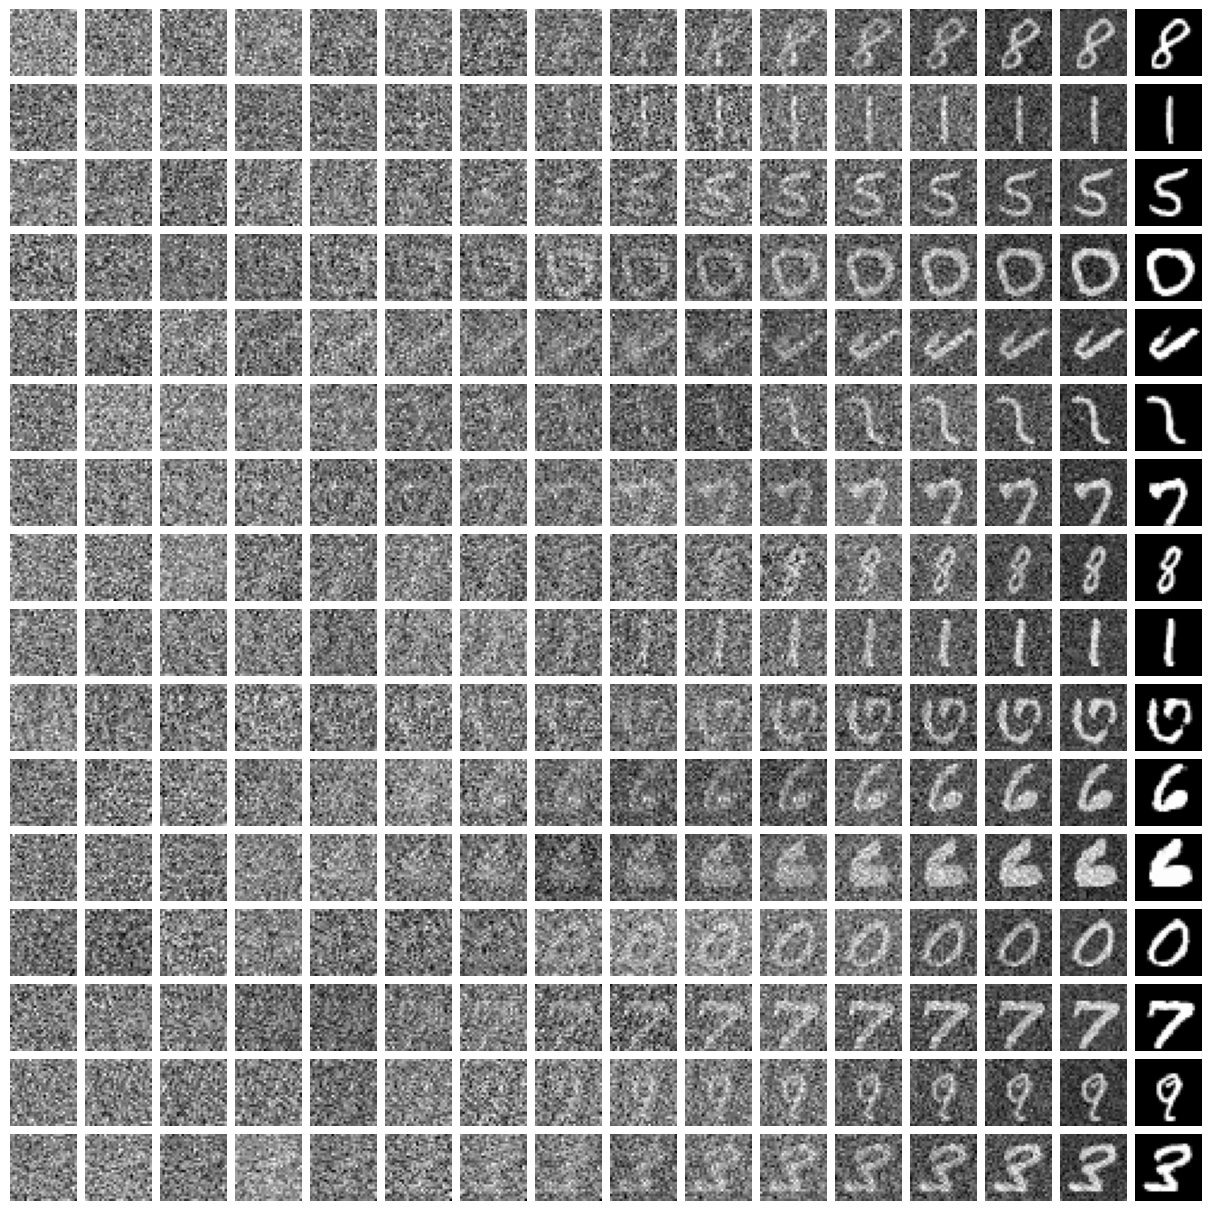

In [42]:
model_download = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model_download.load_state_dict(torch.load("epoch_1000.ckpt", map_location=device))

model_download.to(device)
model_download.eval()

model_trainned = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model_trainned.load_state_dict(torch.load("model.ckpt", map_location=device))

model_trainned.to(device)
model_trainned.eval()


generated_images = gaussian_diffusion.sample(model_trainned, image_size=28, batch_size=64, channels=1)

# generate new images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

# imgs = generated_images[-1].reshape(8, 8, 28, 28)
imgs = generated_images[-1].cpu().numpy().reshape(8, 8, 28, 28)

for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

# show the denoise steps
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(16, 16)

for n_row in range(16):
    for n_col in range(16):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        t_idx = (timesteps // 16) * n_col if n_col < 15 else -1
        img = generated_images[t_idx][n_row].cpu().numpy().reshape(28, 28)
        f_ax.imshow((img+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")